In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

/Users/anna-alexandradanchenko/local/JobTitleClassification/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# EDA
### Import Data

In [3]:
job_level_data = pd.read_excel("data/JobLevelData.xlsx")
job_level_data.head()

,Title,Column 1,Column 2,Column 3,Column 4
0,Vice President / Director of Systems Engineering,Vice President,NaN,NaN,NaN
1,Systems Engineer; Systems Architect,Manager,Individual Contributor/Staff,NaN,NaN
2,"Executive Director, Global IT Infrastructure /...",Director,Chief Officer,NaN,NaN
3,CTO/Executive Director of Technology Services,Director,Chief Officer,NaN,NaN
4,"Vice President, CIO",Vice President,NaN,NaN,NaN


### Check for Rows with all NaNs

In [4]:
nan_rows = job_level_data[job_level_data.drop(columns=['Title']).isna().all(axis=1)]
nan_rows

,Title,Column 1,Column 2,Column 3,Column 4
29,CINO,NaN,NaN,NaN,NaN
341,Ticari Subesi Muduru,NaN,NaN,NaN,NaN
511,"Governor, Chair of Board Risk and Audit Commit...",NaN,NaN,NaN,NaN
764,"Former Director, Compensation and Benefits",NaN,NaN,NaN,NaN
829,Release of Information Tech II,NaN,NaN,NaN,NaN
1257,"Shareholder, Chair of Tax Section",NaN,NaN,NaN,NaN
1406,"Global People Systems, Processes and Informati...",NaN,NaN,NaN,NaN
1713,Supplier Quality Engineer,NaN,NaN,NaN,NaN
1785,RC Environmental and Cyber Specialized Subscri...,NaN,NaN,NaN,NaN
2182,Senior Independedirector and Chair of the Cust...,NaN,NaN,NaN,NaN


### Join Columns values into a single list

In [5]:
job_level_data["Label"] = job_level_data.drop(columns=["Title"]).values.tolist()
job_level_data.drop(columns=["Column 1", "Column 2", "Column 3", "Column 4"], inplace=True)

def remove_nans_from_array(list):
    return [label for label in list if not pd.isna(label)]

job_level_data["Label"] = job_level_data["Label"].apply(remove_nans_from_array)
job_level_data["Label"] = job_level_data["Label"].apply(lambda labels: sorted(labels))
job_level_data

,Title,Label
0,Vice President / Director of Systems Engineering,[Vice President]
1,Systems Engineer; Systems Architect,"[Individual Contributor/Staff, Manager]"
2,"Executive Director, Global IT Infrastructure /...","[Chief Officer, Director]"
3,CTO/Executive Director of Technology Services,"[Chief Officer, Director]"
4,"Vice President, CIO",[Vice President]
...,...,...
2235,Net Software Architect and Team Project Lead,[Manager]
2236,Solutions Architect & Technical Lead,"[Individual Contributor/Staff, Manager]"
2237,"Manager, Salesforcecom Administration and Rele...",[Manager]
2238,Innovation Automation Architect,[Manager]


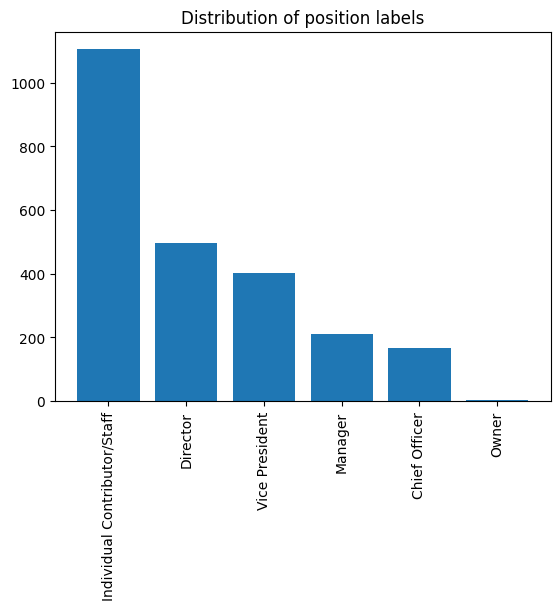

In [6]:
labels_list = [label for labels_list in job_level_data["Label"] for label in labels_list]
labels_count = sorted(Counter(labels_list).items(), key=lambda x: x[1], reverse=True)
labels_count_keys, labels_count_values = zip(*labels_count)

fig, ax = plt.subplots()
ax.bar(labels_count_keys, labels_count_values)
ax.set_title('Distribution of position labels')
plt.xticks(rotation=90)  # Rotate x-axis labels

plt.show()

In [7]:
job_level_data[job_level_data["Label"].apply(lambda labels: "Owner" in labels)]

,Title,Label
22,CoFounder & CTO,"[Chief Officer, Owner]"
119,"Chief Operating Officer, Co-Founder","[Chief Officer, Owner]"
1222,"Co-Owner, Vice President and General Counsel",[Owner]
1933,"Founder, COO","[Chief Officer, Owner]"


This is a big problem of class underrepresentation. Check if we can hard code the labels based on if the title consists "Owner" or "Founder" / can we assume that this class might be labeled later? 

In [8]:
job_level_data[job_level_data["Title"].apply(lambda title: "Owner" in title)]

,Title,Label
30,Owner & Data Architect,"[Chief Officer, Manager]"
896,"Senior Manager Product Owner, Wireless Expansi...","[Director, Manager, Vice President]"
998,Co-Owner & Marketing Manager,"[Chief Officer, Manager]"
1054,Practice Owner,[Individual Contributor/Staff]
1222,"Co-Owner, Vice President and General Counsel",[Owner]
1481,In App Learning Owner Software,[Individual Contributor/Staff]
1566,Owner Services Coordinator,[Individual Contributor/Staff]
1632,Owner / Franchisee,[Chief Officer]
1828,Senior Software Consultant / Product Owner,[Individual Contributor/Staff]
1847,"Product Owner Digital, Data and IS Direction",[Manager]


In [9]:
mlb = MultiLabelBinarizer()
one_hot_encoded_labels = mlb.fit_transform(job_level_data["Label"])
one_hot_df = pd.DataFrame(one_hot_encoded_labels, columns=mlb.classes_)
job_level_data["Label"] = one_hot_df.values.tolist()
job_level_data

,Title,Label
0,Vice President / Director of Systems Engineering,"[0, 0, 0, 0, 0, 1]"
1,Systems Engineer; Systems Architect,"[0, 0, 1, 1, 0, 0]"
2,"Executive Director, Global IT Infrastructure /...","[1, 1, 0, 0, 0, 0]"
3,CTO/Executive Director of Technology Services,"[1, 1, 0, 0, 0, 0]"
4,"Vice President, CIO","[0, 0, 0, 0, 0, 1]"
...,...,...
2235,Net Software Architect and Team Project Lead,"[0, 0, 0, 1, 0, 0]"
2236,Solutions Architect & Technical Lead,"[0, 0, 1, 1, 0, 0]"
2237,"Manager, Salesforcecom Administration and Rele...","[0, 0, 0, 1, 0, 0]"
2238,Innovation Automation Architect,"[0, 0, 0, 1, 0, 0]"


### Tokenization

In [10]:
RANDOM_SEED = 42
tokenizer = BertTokenizer.from_pretrained('bert-base-cased') #not using cased model for a reason

In [11]:
def split_text(text):
    return tokenizer.tokenize(text)

print("Maximum lengths of tokenized sentence: ", job_level_data["Title"].apply(split_text).apply(len).max())

Maximum lengths of tokenized sentence:  24


In [12]:
# handle data preprocessing
class JobTitlesDataset(Dataset):
    def __init__(self, titles, labels, tokenizer, max_len):
        self.titles = titles
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len  # maximum length of tokenized sentence

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, item):
        encoded_data = self.tokenizer.encode_plus(
            self.titles[item],
            add_special_tokens=True,  # tokens required for BERT
            max_length=self.max_len,
            return_token_type_ids=False,  # no sentence pair task
            padding='max_length',
            truncation=True,
            return_attention_mask=True,  # differentiate between padding and data
            return_tensors='pt'
        )
        return {
            'input_ids': encoded_data['input_ids'],
            'attention_mask': encoded_data['attention_mask'],
            'labels': torch.tensor(self.labels[item], dtype=torch.float)
        }

### Train Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    job_level_data['Title'],
    job_level_data['Label'],
    test_size=0.2,
    random_state=RANDOM_SEED,
    shuffle=True
)

print(f"Train data: {X_train.shape}")
print(f"Test data: {X_test.shape}")

Train data: (1792,)
Test data: (448,)


### Model Definition

In [14]:
class JobTitleClassifier(nn.Module):
    def __init__(self):
        super(JobTitleClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased') # pre-trained bert model
        self.dropout = torch.nn.Dropout(0.3) # regularization
        self.linear = torch.nn.Linear(768, 1) # classification 
    
    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids, attention_mask)
        output = self.dropout(output.pooler_output)
        output = self.linear(output)
        return output

model = JobTitleClassifier().to(device)

In [ ]:
def train_classifier(): 
    